In [2]:
import tensorflow as tf
import numpy as np
import os
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt

C:\Users\kouta\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
sess = tf.Session()

def gaussian(x,sigma,mu):
    #分散共分散行列の行列式
    det = np.linalg.det(sigma)
    #分散共分散行列の逆行列
    inv = np.linalg.inv(sigma)
    n = x.ndim
    tmp = (x - mu).dot(inv)
    diag = np.sum(tmp*(x - mu),axis=1)
    return np.exp(-diag/2.0) / (np.sqrt((2 * np.pi) ** n * det))

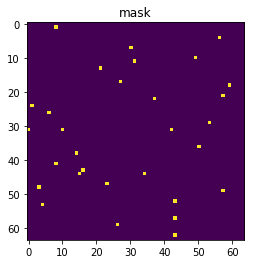

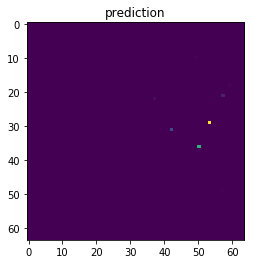

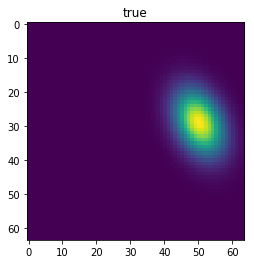

In [34]:
X, Y = np.meshgrid(np.arange(0, 64, 1), np.arange(0, 64, 1)) # X座標,Y座標

dataNum = 30

# マスク画像
mask_X = [int(64*i) for i in [np.random.rand() for _ in range(dataNum)]]
mask_Y = [int(64*i) for i in [np.random.rand() for _ in range(dataNum)]]

mask = np.zeros([64,64])
for i,j in zip(mask_X,mask_Y):
    mask[i,j] = 1
plt.imshow(mask)
plt.title("mask")
plt.show()
    
# 予測画像
img = np.reshape(gaussian(np.c_[X.ravel(),Y.ravel()], np.array([[24,10],[10,42]]), [50,29]),[64,64])
# img = np.ones([64,64])/4096
plt.imshow(img)
plt.imshow(img*mask)
plt.title("prediction")
plt.show()
# print(np.sum(img))
x = tf.Variable(img[np.newaxis,:,:,np.newaxis]) #予測値


# 真値画像
# img = np.reshape(gaussian(np.c_[X.ravel(),Y.ravel()], np.array([[32,10],[10,32]]), [26,32]),[64,64])
plt.imshow(img)
plt.title("true")
plt.show()
# print(np.sum(img))
y = tf.Variable(img[np.newaxis,:,:,np.newaxis]) #真値

In [35]:
def compKL(p1,p2,smallV=1e-10):
    kl = tf.reduce_sum(p1*(tf.math.log(p1+smallV) - tf.math.log(p2+smallV)))
    return kl

def compSpatialHist(x,kSize=16,sSize=2,isNormMode='sum',thre=0.05):
    # binarize images
#     x_bin = tf.nn.relu(x - thre)
#     x_bin = tf.math.sign(x_bin)

    # kernel with all ones
    kernel = np.ones([kSize,kSize,1,1])
    kernel = tf.constant(kernel, dtype=tf.float64)

    # histogram using conv2d
    x_conv = tf.nn.conv2d(x,kernel,strides=[1,sSize,sSize,1],padding='VALID')
    shape = tf.shape(x_conv)
    x_conv_flat = tf.reshape(x_conv,[shape[0],shape[1]*shape[2]])

    if isNormMode == 'max':
        x_conv_flat = x_conv_flat/tf.reduce_max(x_conv_flat,axis=1,keepdims=True)
    elif isNormMode == 'sum':
        x_conv_flat = x_conv_flat/tf.reduce_sum(x_conv_flat,axis=1,keepdims=True)

    x_conv = tf.reshape(x_conv_flat,[shape[0],shape[1],shape[2]])

    return x_conv

hist_x = compSpatialHist(x)
hist_y = compSpatialHist(y)

In [36]:
kl_loss = compKL(hist_x,hist_y)
grad = tf.gradients(kl_loss,x)[0]

sess.run(tf.global_variables_initializer())

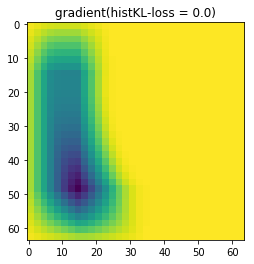

[[-1.89441025e-02 -1.89441025e-02 -3.78618429e-02 ... -2.15452923e-08
  -1.28479216e-08 -1.28479216e-08]
 [-1.89441025e-02 -1.89441025e-02 -3.78618429e-02 ... -2.15452923e-08
  -1.28479216e-08 -1.28479216e-08]
 [-3.78878608e-02 -3.78878608e-02 -7.57169531e-02 ... -3.03137560e-08
  -1.81093742e-08 -1.81093742e-08]
 ...
 [-3.78917493e-02 -3.78917493e-02 -7.57834985e-02 ... -1.40477194e-07
  -6.99598091e-08 -6.99598091e-08]
 [-1.89458746e-02 -1.89458746e-02 -3.78917493e-02 ... -1.01546744e-07
  -5.04711819e-08 -5.04711819e-08]
 [-1.89458746e-02 -1.89458746e-02 -3.78917493e-02 ... -1.01546744e-07
  -5.04711819e-08 -5.04711819e-08]]


In [37]:
grad_value, kl_value = sess.run([grad,kl_loss])
plt.imshow(grad_value[0,:,:,0])
plt.title("gradient(histKL-loss = {})".format(kl_value))
plt.show()

print(grad_value[0,:,:,0])

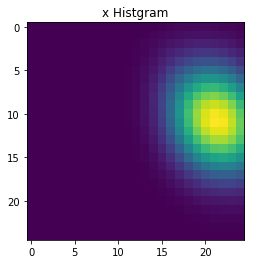

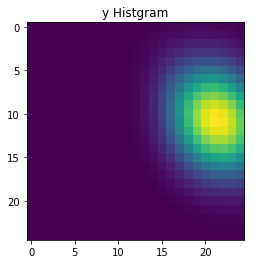

In [38]:
xhist_value,yhist_value = sess.run([hist_x,hist_y])
plt.imshow(xhist_value[0,:,:])
plt.title("x Histgram")
plt.show()

plt.imshow(yhist_value[0,:,:])
plt.title("y Histgram")
plt.show()